In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
import glob
import os
import numpy as np
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from fmri_nb_helpers import get_img_path, get_filt_tval_img, plot_filt_tval_img, get_filt_diff_tval_img, plot_filt_diff_tval_img, get_mean_cor_df

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 
- rt = reaction time; amplitude = demeaned RT

Citing Grinband et al. (2008) people agree that reaction times must be taken into account but model them in different ways. Schonberg, Poldrack et al. papers use overall response time for event and parametric regressor as well as a parametric RT regressor. Many in the rest of the decision making literature use boxcars with RT durations (e.g. Dunsmoor et al. (2011), Chang et al. (2011), Chang and Sanfey (2013), Shuck et al. (2016)). 

Since it is common to use boxcars with RT duration and I don't know others who model RT the way Poldrack et al. do I will present those results below.

# Building block models

## Model 1: fractalProb_ev + stim_ev + choiceShift_st + reward_ev

Correlation between regressors averaged across subjects and runs

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "1")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'reward_ev']
mnum = '1'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Check for left motor cortex activity. Cross is the precentral gyrus peak reported in Hare et al.

In [ ]:
reg = 'choiceShift_st'
mnum = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

plot_filt_tval_img(reg, mnum = mnum, cut_coords = cut_coords, draw_cross = draw_cross)

Motor cortex activity is a little ventral than expected but more consistent for choiceShift regressor. It is, however, not lateralized to the left.

## Model 1a: fractalProb_ev + stim_ev + choiceShiftLeft_st + choiceShiftRight_st + reward_ev

In [ ]:
plot_filt_diff_tval_img(reg="choiceShiftLeft_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1a", reg2 = "choiceShiftLeft_st", cut_coords = cut_coords)


## Model 2: Model 1 + fractalProb_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "2")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '2'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))

In [ ]:
reg = 'fractalProb_par'
mnum = '2'
plot_filt_tval_img(reg, mnum = mnum)

# Model 3: Model 2 + valBundleSum_par + valChosenMinusUnchosen_par + reward_ev + reward_par + rpeLeftRightSum_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "3", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par'])

## Event regressors

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


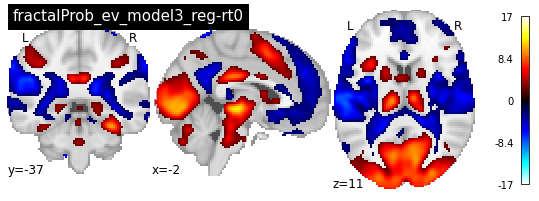

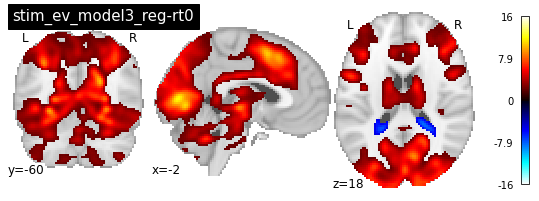

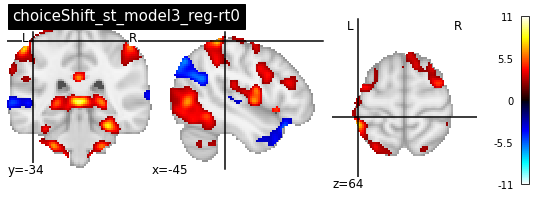

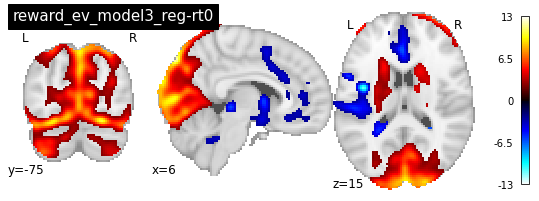

In [7]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '3'

for reg in regs:
    if reg == 'choiceShift_st':
        plot_filt_tval_img(reg, mnum = mnum, draw_cross=True, cut_coords = (-45, -34, 64))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

## Parametric regressors

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosen_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSum_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05


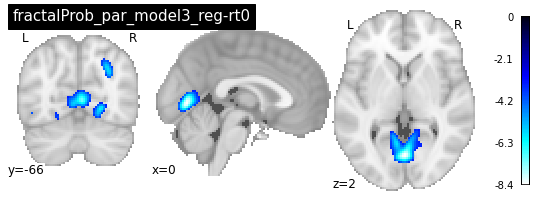

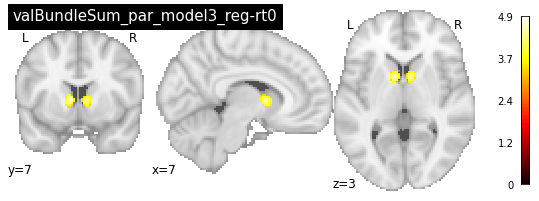

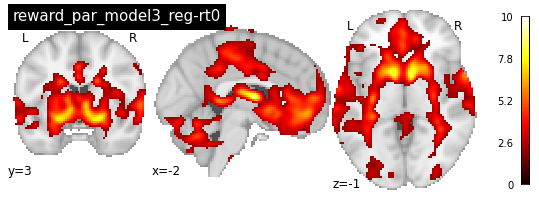

In [8]:
regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par']
mnum = '3'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [12]:
# plot_filt_tval_img("valChosenMinusUnchosen_par", mnum = "3", nofilt=True, t_threshold=2.3, cut_coords=(-52, -48, 48))
# plot_filt_tval_img("valChosenMinusUnchosen_par", mnum = "3", nofilt=True, t_threshold=2.3, cut_coords=(24, 12, 6))
# plot_filt_tval_img("rpeLeftRightSum_par", mnum = "3", nofilt=True, t_threshold=2.3, cut_coords=(2, 34, 12))

# Failed attempts at decreasing variance captured by reward_par 

## Model 4: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumEarly_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "4", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par']
mnum = '4'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "4", nofilt=True, t_threshold=2.3, cut_coords=(-52, -48, 48))
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "4", nofilt=True, t_threshold=2.3, cut_coords=(24, 12, 6))
plot_filt_tval_img("rpeLeftRightSumEarly_par", mnum = "4", nofilt=True, t_threshold=2.3, cut_coords=(2, 34, 12))

## Model 5: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumLate_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "5", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumLate_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumLate_par']
mnum = '5'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=2.3, cut_coords=(-52, -48, 48))
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=2.3, cut_coords=(24, 12, 6))
plot_filt_tval_img("rpeLeftRightSumLate_par", mnum = "5", nofilt=True, t_threshold=2.3, cut_coords=(4, -38, -2))

## Model 6: what happens to rpe without reward_par - nothing. Still doesn't survive.

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "6", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'rpeLeftRightSum_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'rpeLeftRightSum_par']
mnum = '6'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosen_par", mnum = "6", nofilt=True, t_threshold=2.3)
plot_filt_tval_img("rpeLeftRightSum_par", mnum = "6", nofilt=True, t_threshold=2.3, cut_coords =(2, 32, -2))

## Model 7: Does anything for rpe survive with only one fractal included? No.

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "7", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftFractal_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftFractal_par']
mnum = '7'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("rpeLeftFractal_par", mnum = "7", nofilt=True, t_threshold=3, cut_coords=(2, 28, 12))

# To solve

- Reward screen - RPE and parametric reward regressor
    - Rewarded vs not rewarded contrast
    - Same RPE regressor for all subjects using average parameter estimates? Very old school and probably wouldn't power the RPE regressor massively.
    - What is on the screen? What might be processed?
        - Left and fractal reward. Whether a fractal is rewarded matters only to the degree it updates beliefs but since these two regressors would be expected to affect the same are at the same time we combine them into one by summing them `rpeLeftRightSum_par`. Results of `rpeLeftRightSumEarly_par` might point towards an initial processing of these outputs before the total trial reward.
        - Reward attribute (red square)`rewardedAttrFractal_st` and `rewardedAttrLottery_st` + their contrast
        - How surprising the reward attribute is. `rewardedAttrSurprise_par`.If rewardFractal then `1-wpFrac`, if rewardLottery `1-(1-wpFrac)=wpFrac`. Note that this is **not** entirely a learning signal since the output is determined by the design more than the subjects' behavior but it might bias behavior nonetheless.
        - Total reward amount `reward_par`
        - Was there a reward for the trial `rewarded_st` and `notRewarded_st` + their contrast
- Value comparison
    - Does limiting the value sum regressor to the beginning (valBundleSum**Early**_par) make valChosenMinusUnchosenLate_par capture more variance?
    
- If these early/late regressor's have effects then maybe eye-tracking is a good idea for this paradigm.

# Model 8: Expanded reward screen modeling

Note the correlation between `reward_par`, `rewarded_st` and `notRewarded_st`

In [11]:
get_mean_cor_df(reg_rt = "0", mnum = "8", regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valBundleSum_par,valChosenMinusUnchosen_par,reward_par,rpeLeftRightSum_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.091609,-0.119587,-0.013040,-0.002867,0.022245,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.043996,-0.068729,-0.638223,0.017658,0.020425,-0.341935,1.000000
5,reward_par,-0.013040,0.065680,0.068950,1.000000,-0.021951,-0.028461,0.613609,-0.638223
8,rewardedAttrSurprise_par,0.022245,-0.022482,-0.059808,-0.028461,-0.014241,1.000000,-0.018515,0.020425
9,rewarded_st,-0.008796,0.039643,0.031422,0.613609,-0.018288,-0.018515,1.000000,-0.341935
10,rpeLeftRightSum_par,-0.002867,0.039107,0.005916,-0.021951,1.000000,-0.014241,-0.018288,0.017658
12,valBundleSum_par,-0.091609,1.000000,-0.018201,0.065680,0.039107,-0.022482,0.039643,-0.043996
13,valChosenMinusUnchosen_par,-0.119587,-0.018201,1.000000,0.068950,0.005916,-0.059808,0.031422,-0.068729


Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosen_par, model = 8, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSum_par, model = 8, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for rewardedAttrFractalVsLottery, model = 8, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


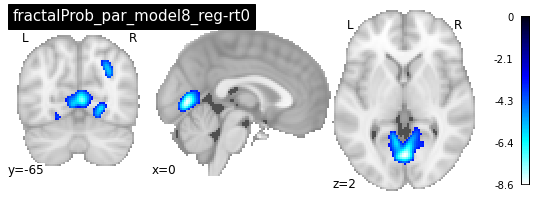

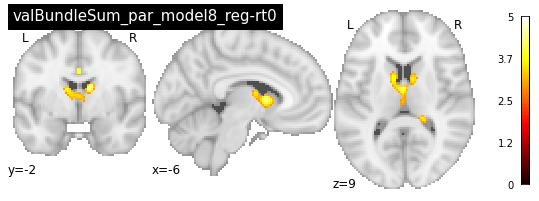

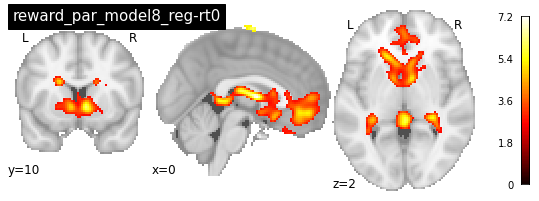

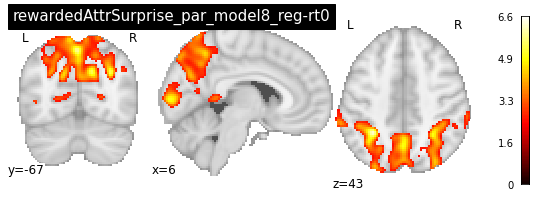

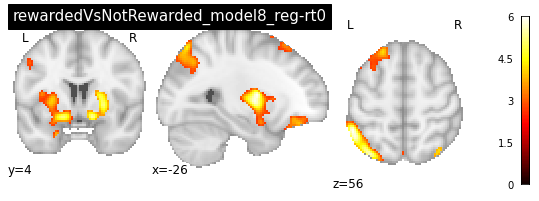

In [3]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par', 
         'rewardedAttrFractalVsLottery', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
mnum = '8'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

- Remore reward attribute (red square)`rewardedAttrFractal_st` and `rewardedAttrLottery_st` + their contrast. Nothing survives for them.
- What to do about value comparison and rpe?
    - Timing: `valBundleSumEarly_par`, `valChosenMinusUnchosenLate_par`, `rpeLeftRightSumEarly_par`

# Model 9: Expanded reward screen modeling with shifted value and rpe regressors - no improvement

Shifting the value sum regressors makes it less powerfull and nothing survives for the rpe sum when looking at the first second of the reward screen either.

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosenLate_par, model = 9, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSumEarly_par, model = 9, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


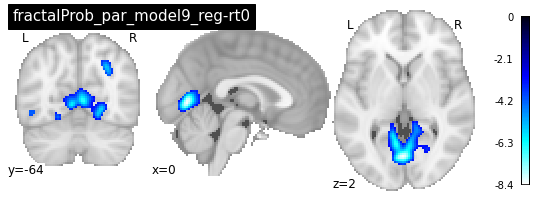

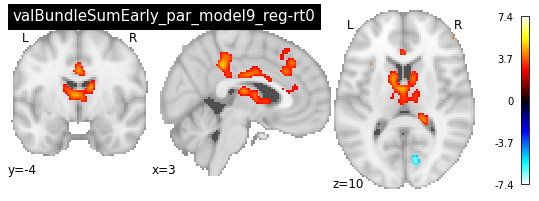

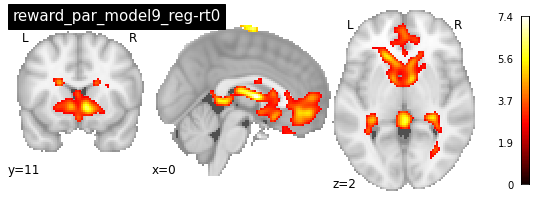

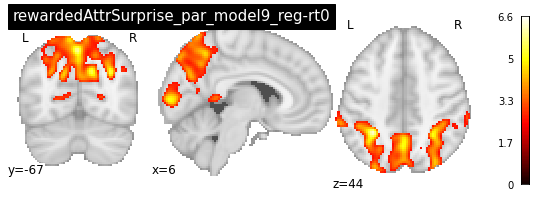

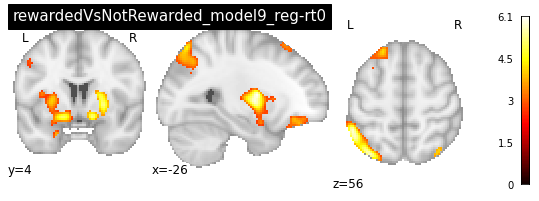

In [15]:
regs = ['fractalProb_par','valBundleSumEarly_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par', 
        'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
mnum = '9'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

# Model 10: Relative value and rpe regressors

Relative value is a lot more scattered and relative rpe still doesn't survive.

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeRelativeLeftFractal_par, model = 10, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


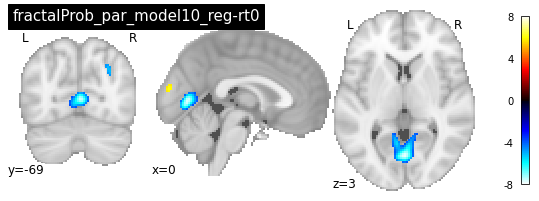

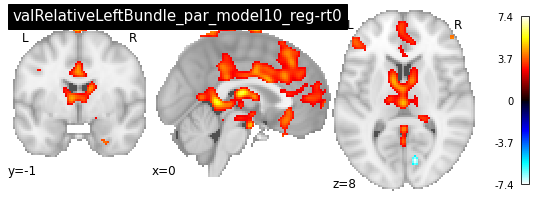

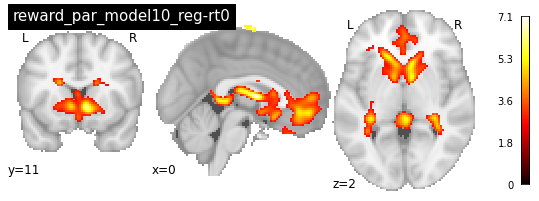

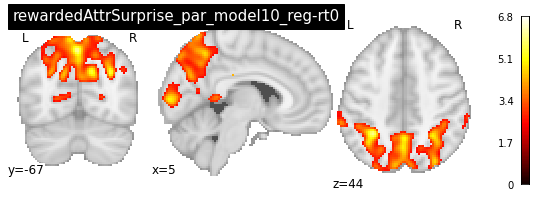

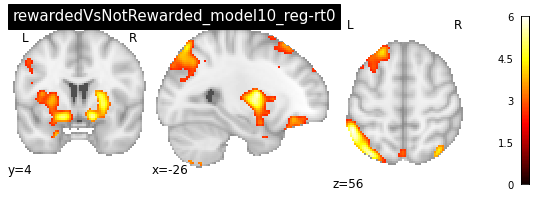

In [17]:
regs = ['fractalProb_par','valRelativeLeftBundle_par', 'reward_par', 'rpeRelativeLeftFractal_par', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
mnum = '10'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

# Where is the "learning" signal?

The expanded modeling of the reward screen reduced some of the variance associated with the `reward_par` regressor by loading some onto the `rewardedAttrSurprise_par` regressor and the `rewardedVsNotRewarded` contrast.

It did not, however, result in anything surviving for `rpeLeftRightSum_par` (model 8), `rpeLeftRightSumEarly_par` (model 9) or `rpeRelativeLeftFractal` (model 9).

Behavioral analyses show, however, that subjects are more likely to choose the bundle with the better fractal later in the task suggesting that subjects **learn** fractal values.

We also know, that behavior depends more on the fractal value difference the more **relevant** the fractals are

When would learning happen? During the reward screen. But there is a lot of information to process on this screen so maybe learning is not as consistent as the current behavioral model would suggest but context-dependant.

Model where continously updated rpe's expression is weighted by its relevance for the trial's reward:
- Does how much you learn depend on how relevant the fractals were for that trial? `rpeWeightedByRelevance_par = rpeLeftRightSum_par` * `fractalProb_par` (model11a) Or by perceived relevance? `rpeWeightedByPerceivedRelevance_par = rpeLeftRightSum_par * wpFrac` (model11b)

Models that imply rpe's that are **not** updated after each trial. For these I should first fit the behavioral model and do a model comparison with the model that updates the rpe after each trial.
- Do you only learn about the fractals when they are the rewarded attribute? `rpeWhenFractalRewarded_par = np.where(fractalDraw, rpeLeftRightSum_par, 0)` (model12) - need to recompute rpe's
- Do you only learn about the fractal in the chosen bundle? `rpeChosenBundleFractal_par = np.where(choiceLeft, rpeLeft, rpeRight)` (model13) - need to recompute rpe's